# Perceptron Demo - Distinguishing Traces of Schizophrenia

## CSCI 4850-5850 - Neural Networks

Being able to detect traces of schizophrenia in a person's brain can be a valuable thing. Diagnosing schizophrenia can be done in a variety of ways, such as physical examinations, tests and screenings, or psychiatric evaluation. Obtaining a solid diagnosis can be difficult and time/cost consuming. In our project, we wanted to apply the use of neural nets to try and detect traces of schizophrenia and accurately diagnose it.

## What data to use - fMRI

There are several ways to detect schizophrenia, but one of the most popular ways is through brain scans. Since schizophrenia is diagnosed as a mental disorder, the brain is directly correlated with it. The dopamine produced by the brain is tied to the hallucinations that schizophrenic patients see or hear. A good way to detect the activity of the brain is through Functional Magnetic Resonance Imaging (fMRI). An fMRI measures the flow of blood in one's brain. By viewing an fMRI, a doctor can see if certain activity/inactivity in a region of the patient's brain could be a sign of schizophrenia. So, since we have an image that can tell us if a patient has traces of schizophrenia, we can plug that into a neural net to see if it can detect it for us! Hopefully, this will allow doctors to just be able to scan a patient's brain, plug in into the neural net, and wait for the net to decide if that patient has schizophrenia or not. However, we want the highest possible accuracy we can get in order to cut down on misdiagnoses, time and cost.

Since fMRI is a highly valuable dataset with a lot of information packed into a few dimensions, this proves it to be difficult to use in a neural net. An fMRI is a scan of the patient's brain sliced into several regions over several timestamps, which makes it difficult to efficiently feed into a neural net. 

The data that we'll be using for this demo is provided by The Center for Biomedical Research Excellence (COBRE). This dataset contains MR data from 72 schizophrenic patients and 75 MR scans from healthy controls. The ages of these test patients range from 18 to 65.

## Step 1: Loading and Viewing the data

In order to use the COBRE data set, we need to use a few tools: `nilearn` and `nibabel`

In [8]:
# nilearn helps with loading and handling of the COBRE dataset and is actually built to help run this dataset
import nilearn
from nilearn import plotting
from nilearn import image
from nilearn import datasets

In [ ]:
# nibabel also helps with the testing of the dataset
from nibabel.testing import data_path
import nibabel as nib

# import other basic necessities
import os
import numpy as np
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

from nilearn import image
from nilearn import input_data
from sklearn.externals.joblib import Memory   # A "memory" to avoid recomputation

from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold

Now that we have our tools all set out, lets start unpacking the data.

In [9]:
# Get dataset with nilearn function
# if not downloaded, will download. If already downloaded, will uses local version
dataset = nilearn.datasets.fetch_cobre(n_subjects=146, 
                                       data_dir="/nfshome/sandbox/perceptron",
                                       url=None,
                                       verbose=0)


In [10]:
file_paths = dataset["func"]  #list of file names
confounds = dataset["confounds"]  #list of confound file names
phenotypes = dataset["phenotypic"] # Contains phenotypic information of patients, we only use schizophrenia diagnosis

# sort lists so they are all corresponding by file names 0-146
phenotypes.sort(0) 
file_paths.sort() 
confounds.sort()
#file_paths is now a regular python list of the file paths to the fmri scans
#phenotypes is now a np.recarray of np.records storing patient info

# number 74 is misisng samples so it needs to be removed
del file_paths[74]                          
del confounds[74]

In [11]:
# get just the diagnosis information from the phenotypes
diagnosis = phenotypes['diagnosis']
diagnosis_converted = []
#this stem is necessary to convert np.byte array into strings, and then fit those strings into 2 categories:
#Schizophrenia or no Schizophrenia
for item in diagnosis:
    s = item.decode('UTF-8')
    if s != "None":
        diagnosis_converted.append(float(1))   #person has schizophrenia
    else:
        diagnosis_converted.append(float(0))   #person doesn't have schizophrenia

del diagnosis_converted[74]  

Y = np.array(diagnosis_converted)

The below part isn't necessary, it only shows the original shape of the data before we do some more modifications to it in order for it to fit into the neural net easier.

In [12]:
y_temp = np.array(diagnosis_converted)
y_temp = keras.utils.to_categorical(y_temp, len(np.unique(y_temp))) #one hot encoding

# Make x train from the file paths
scans = []
for item in file_paths:
    scan = nib.load(item)
    data = scan.get_fdata()
    scans.append(data)
x_temp = np.array(scans)

#X train is now 145 different fmri scans, with dimensions 27x32x26x150
#the 27x32x26 is length, width, and height
#the 150 is time, there are 150 different 3d 'voxels' or times for each full fmri scan
x_temp.shape

(145, 27, 32, 26, 150)

Now that we've loaded the data into an array without modifying it at all, we can see how each image is measured. Starting from left to right, there are 145 images, of length 27, width 32, and height 26 taken at 150 different timestamps.

## Step 2: Condensing the data

As you can see from the size of the array above, there are a lot of dimensions in a single fMRI scan. The fact that it is sliced into 26 different layers and stretched across 150 different timestamps also adds complexity in that we don't know what slice or timestamp to use? If we use all of them, it will slow the training of the neural net down and could add unnecessary noise to our data.

To fix this, we are going to mask the data using a brain atlas. We will use a predefined probabilistic brain atlas called the MSDL atlas. This gives us 39 spatial reigons of interest and averages together our FMRI blood oxygen values for all the voxels in each these reigons of interest. This process significantly reduces the size of the data and other noisy factors.

In [ ]:
# this is a brain anatomical atlas template, that gives us brain reigons with their labels
msdl_atlas_dataset = nilearn.datasets.fetch_atlas_msdl(data_dir="/nfshome/sandbox")

mem = Memory('nilearn_cache')

# mask the data, used the atlas template as the mask img.
masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    low_pass=.5, high_pass=0.01, t_r=2.0, standardize=True,
    memory='nilearn_cache', memory_level=1, verbose=0)
masker.fit()

# for each of our fmri scams, compute confounds, transform them into mask, and append
# to time series list
subject_time_series = []
for file_path, confound in zip(file_paths, confounds):
    # Computing some confounds
    hv_confounds = mem.cache(image.high_variance_confounds)(
        file_path, n_confounds=10)

    region_ts = masker.transform(file_path,
                                 confounds=[hv_confounds, confound])
    subject_time_series.append(region_ts)

## Step 3: Connecting the regions

Now that we've condensed the data into the 39 regions that we want, we can start to compute a covariance matrix on our masked data. This allows us to obtain information on how our reigons of interest are connecting with each other.

In [15]:
correlation_measure = ConnectivityMeasure(kind='covariance',vectorize=True)
correlation_measure.fit(subject_time_series)

matrices = correlation_measure.transform(subject_time_series)
correlation_measure2d = ConnectivityMeasure(kind='covariance',vectorize=False)
correlation_measure2d.fit(subject_time_series)

matrices2d = correlation_measure2d.transform(subject_time_series)

# function code source: nilearn documentation
# https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html#sphx-glr-auto-examples-03-connectivity-plot-group-level-connectivity-py

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

The grid images below represent our covariance matrices. The values range from 1 to -1 (red to blue). The X and Y axis represent our 39 brain reigons where each two reigons have a specific shared covariance value that is represented by the color at their specified coordinate.

The connectome is made from the covariance matrices. Connections are made between each of the 39 reigons as outlined in the MSDL atlas. Each reigon is shown as connected to each other. Reigons with a stronger covariance are represented as having a stronger connection. The connectome is made based off of the assumption that a higher covariance/correlation represents a stronger connection.

Let's go ahead and take a look at the grids we just created, along with how each reagion is connected within the brain.

'Covariance matrices of first 4 subjects'

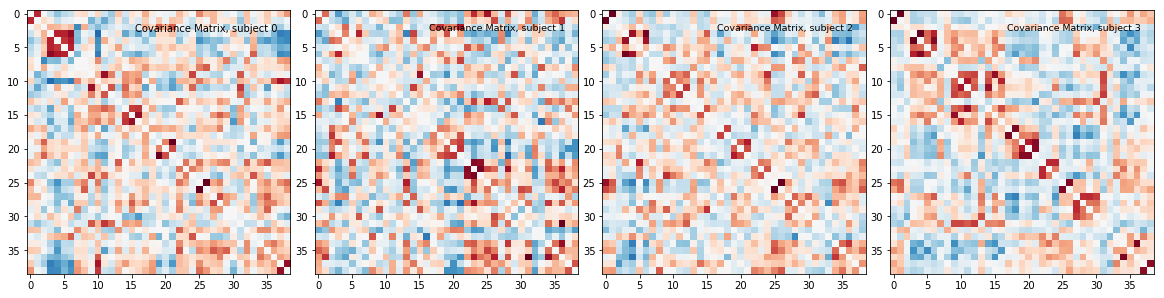

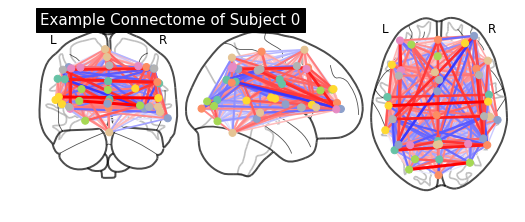

In [16]:
msdl_coords = msdl_atlas_dataset.region_coords
display("Covariance matrices of first 4 subjects")
plot_matrices(matrices2d[:4], "Covariance Matrix")
plotting.plot_connectome(matrices2d[0], msdl_coords,
                         title='Example Connectome of Subject 0')

## Step 4: The Neural Net

First, we need to take our covariance matrix and flatten it out into a 1d vector. The covariance matrix for each subject becomes our input to the neural network.

In [17]:
X = np.array(matrices)
X.shape

(145, 780)

Now that looks a lot cleaner than the 5D array that we initially started with! 

In [18]:
x_train = X[:105]
x_test = X[105:]
y_train = Y[:105]
y_test = Y[105:]

For this neural net, we are going to use a multilayer feedforward neural network with 1 hidden layer of 450 units. The hidden layer has a relu activation function, and the output layer has a sigmoid activation function. A binary cross entropy loss function is used as this is a binary classification problem.

We employ a dropout layer with 10% dropout on the input layer in order to achieve slightly better generalization. We also use batch normalization to normalize hidden layer activations.

In [19]:
input_dim=x_train.shape[1]
output_dim=1
# Multi-layer net with ReLU hidden layer
model = keras.models.Sequential()
model.add(keras.layers.Dropout(0.1, input_shape=(input_dim,)))
model.add(keras.layers.Dense(450,activation='relu',
                            bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.BatchNormalization(momentum=0.8))
# Output layer (size 1), sigmoid activation function
model.add(keras.layers.Dense(output_dim,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
# Display the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 780)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 450)               351450    
_________________________________________________________________
batch_normalization_1 (Batch (None, 450)               1800      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 451       
Total params: 353,701
Trainable params: 352,801
Non-trainable params: 900
_________________________________________________________________
None


We can see the structure of the net below:

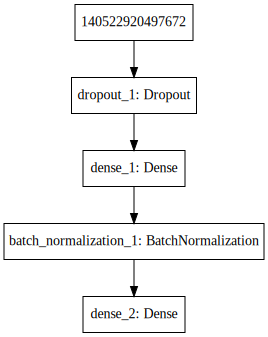

In [20]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Let's take this net for a test drive!

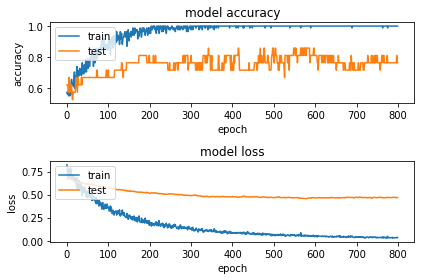

Test loss: 0.7978713750839234
Test accuracy: 0.625


In [21]:
batch_size = len(x_train)
epochs = 800
history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split=0.2)

plt.figure()
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

As you can see, our test accuracy isn't too bad, although it can be improved a little bit. The test loss is a bit high and seems to plateau without going too far down. We'll improve this in the final step below.

## Step 5: K Cross Validation

We can use a Stratified K Cross Validation to get accuracy over multiple class label splits. This way we can train and test over the whole dataset.

In [22]:
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    model = keras.models.Sequential()
    model.add(keras.layers.Dropout(0.1, input_shape=(input_dim,)))
    model.add(keras.layers.Dense(450,activation='relu',
                                bias_initializer=keras.initializers.Constant(0.1)))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    # Output layer (size 1), sigmoid activation function
    model.add(keras.layers.Dense(output_dim,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
    batch_size = len(X[train])
    epochs = 800
    model.fit(X[train], Y[train],
        batch_size=batch_size,
        epochs=epochs,
        verbose=0)
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 81.25%
acc: 75.00%
acc: 93.33%
acc: 78.57%
acc: 71.43%
acc: 78.57%
acc: 85.71%
acc: 85.71%
acc: 57.14%
acc: 64.29%
77.10% (+/- 10.16%)


With this net, you should be getting 77.10% (+/- 10.16%) accuracy with 10 K fold cross validation. This indicates that our network is picking up on differences between Schizophrenic and non-Schizohrenic resting state FMRI data with fairly decent precision.